#### 环境测试

In [61]:
import torch
import torchvision
import numpy as np

In [62]:
x = torch.Tensor(1)

In [63]:
print(x)

tensor([0.])


In [64]:
if torch.cuda.is_available():
    print("GPU可用")

GPU可用


## 载入数据
- 先载入二进制数据
- 再对数据进行转换

In [65]:
def load_mnist(path, data_name,label_name):
    """
        加载数据（二进制）
        path:文件目录
        data_name:数据文件名
        label_name:标签文件名
    """
    import os
    import gzip
    labels_path = os.path.join(path,label_name)
    images_path = os.path.join(path,data_name)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                            offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                            offset=16).reshape(len(labels),28,28) #进行了维度修正,转为张量
    return (images, labels)

In [66]:
path = '/home/ysq/桌面/FashionMnistdata'
images,labels = load_mnist(path,"train-images-idx3-ubyte.gz","train-labels-idx1-ubyte.gz")
print(images.shape,labels.shape)
print(type(images))

test_img,test_label = load_mnist(path,"t10k-images-idx3-ubyte.gz","t10k-labels-idx1-ubyte.gz")
print(test_img.shape,test_label.shape)

(60000, 28, 28) (60000,)
<class 'numpy.ndarray'>
(10000, 28, 28) (10000,)


### 上面加载的数据是二进制源码类型，需要进行转换

In [67]:
import torch.utils.data as Data #An abstract class representing a Dataset

In [68]:
class DealDataset(Data.Dataset):
    """
        初始化数据
    """
    def __init__(self,path,data_name,label_name):
        """
            path:数据路径
            data_name:数据文件名
            label_name:数据标签名
            transforms: torchvision.transforms
        """
        (train_set,train_labels) = load_mnist(path,data_name,label_name)
        
        #将numpy.ndarray转为torch.tensor
        
        self.train_set = torch.from_numpy(train_set)
        
        
        self.train_labels = torch.from_numpy(train_labels)
        
    
    def __getitem__(self, index):
        img,target = self.train_set[index], int(self.train_labels[index])
        return img,target

    def __len__(self):
        """
            返回数据集长度
        """
        return len(self.train_set)

- 初始化数据

In [69]:
trainDataset = DealDataset(path=path,data_name="train-images-idx3-ubyte.gz",label_name="train-labels-idx1-ubyte.gz")
testDataset = DealDataset(path=path,data_name="t10k-images-idx3-ubyte.gz",label_name="t10k-labels-idx1-ubyte.gz")

#### 尝试显示数据集中的一些图片

tensor(9, dtype=torch.uint8)


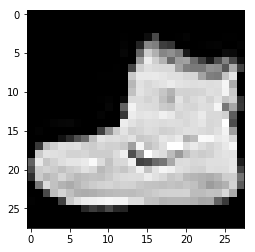

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
eg_image = trainDataset.train_set[0]
eg_label = trainDataset.train_labels[0]
print(eg_label)
plt.imshow(eg_image,cmap='gray')

### 装载数据

In [88]:
#调用torch.utils.data.dataloader装载训练数据和测试数据
train_loader = Data.DataLoader(
    dataset=trainDataset,
    batch_size=100,#批次
    shuffle=False,
)
test_loader = Data.DataLoader(
    dataset=testDataset,
    batch_size=100,
    shuffle=False,
)

#for images, labels in train_loader:
    #print((images))
    #print(labels)

### 建立输出类别映射
- 方便查看

In [89]:
def output_label(label):
    output_mapping = {
        0 : "T-shirt/Top",
            1 : "Trouser",
            2 : "Pullover",
            3 : "Dress",
            4 : "Coat",
            5 : "Sandal",
            6 : "Shirt",
            7 : "Sneaker",
            8 : "Bag",
            9 : "Ankle Boot"
    }
    input = label
    return output_mapping[input]

## 建立CNN
#### 网络由以下层组成：
- 两个 `Sequential Layers`，每个Sequential Layers 包含以下层：
    - 卷积层 `Convolution layer`
        - 卷积核为`3*3`,第一个Sequential Layer的`zero-padding = 1`,
        - 第二个Sequential Layer的`zero-padding=0`,步长都为1
    - `Batch Normalization layer`（批量归一化层）
    - 激活函数 ReLU
    - （最大）池化层 `Max Pooling layer`
         - kernel大小为`2*2`,步长为`2`
    - 全联接层
    - `Dropout layer` 防止过拟合

- 训练数据（图片）通过该网络时的变化过程如下：
-  数据卷积后尺寸的计算公式
\begin{equation}
Output_{size} = (Input_{size}+ZeroPadding\times2-FilterSize_{Convolution})\div Stride+1
\end{equation}
\begin{equation}
输出数据尺寸 = (输入数据尺寸+补偿\times2-卷积核尺寸)\div 步长+1
\end{equation}
    - 第一个卷积层处
        - 输入：`28*28*1` 输出：`28*28*32` 需要32个`filter`
    - 第一个池化层处
        - 输入：`28*28*32` 输出：`14*14*32` 
    - 第二个卷积层处
        - 输入：`14*14*32` 输出：`12*12*64` 需要64个`filter`
    - 第二个池化层处
        - 输入：`12*12*64` 输出：`6*6*64` 
    - 全联接层处
        - 输入：`6*6*64`  输出：`10*1`，表征10类服装
        

In [73]:
import torch.nn as nn

class FashionCNN(nn.Module):
    """
        继承nn.Module，nn.Module是一个building blocks
    """
    def __init__(self):
        """
            初始化FashionCNN类,重载nn.Module的初始化方法 
        """
        super(FashionCNN,self).__init__()
        
        #first sequential layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),#设置的参数就是卷积的输出通道数
            nn.ReLU(),#激活函数选择修正线性单元
            nn.MaxPool2d(kernel_size=2,stride=2)#最大池化层，步长2,kernelsize=2
        )
        
        #second sequential layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #全联接层
        self.fc1 = nn.Linear(in_features=64*6*6,out_features=1000)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1000,out_features=100)
        self.fc3 = nn.Linear(in_features=100,out_features=10)
    def forward(self,x):
        """
            前向传播
            嵌套书写，代表了神经网络前向运行的过程
        """
        foo = self.layer1(x)
        foo = self.layer2(foo)
        foo = foo.view(foo.size(0),-1)#拉成一维向量,准备全连接
        foo = self.fc1(foo)
        foo = self.drop(foo)
        foo = self.fc2(foo)
        foo = self.fc3(foo)
        
        return foo

### 建立一个神经网络实例

In [74]:
model = FashionCNN()

#选择在显卡上运行（如果有的话）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("程序将会运行在",device,"上")

#将网络送至GPU运算
model.to(device)

#LOSS函数选择交叉熵函数
error = nn.CrossEntropyLoss()

#学习率设为0.001
learning_rate = 0.001
#优化器选择Adam
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

程序将会运行在 cuda:0 上
FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=1000, bias=True)
  (drop): Dropout2d(p=0.25)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


### 训练网络

In [75]:
from torch.autograd import Variable

num_epochs = 5 #训练轮数
count = 0

#使用以下列表来可视化loss和准确度
loss_list = []
iteration_list = []
accuracy_list = []


#使用以下列表来可视化每个类的准确度
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images,labels in train_loader:
        #将图片数据和标签数据送至GPU
        #注意：需要进行数据类型转换，不然会报错
        images = images.type(torch.FloatTensor)
        images,labels = images.to(device),labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        #前向传播
        outputs = model(train)
        loss = error(outputs,labels)#计算损失函数
        
        #初始化一个梯度为0
        optimizer.zero_grad()
        
        #误差反向传播
        loss.backward()
        
        #优化调参
        optimizer.step()
        
        count+=1
    
    #进行测试
        if count%50 == 0: #50步测试一个
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images = images.type(torch.FloatTensor)
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
                
                #选择概率最大的输出
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if count%500 == 0:
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.4293985664844513, Accuracy: 87%
Iteration: 1000, Loss: 0.3726092278957367, Accuracy: 88%
Iteration: 1500, Loss: 0.2617042660713196, Accuracy: 88%
Iteration: 2000, Loss: 0.20603130757808685, Accuracy: 89%
Iteration: 2500, Loss: 0.1632489413022995, Accuracy: 90%
Iteration: 3000, Loss: 0.14189253747463226, Accuracy: 90%


### 可视化损失与正确率(全局)

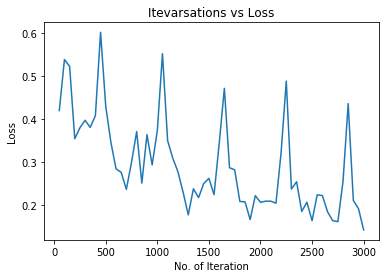

In [79]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Itevarsations vs Loss")
plt.show()

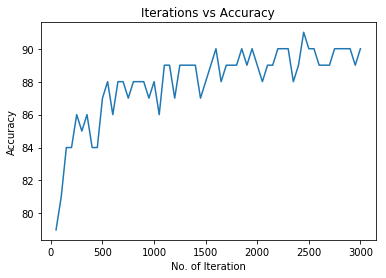

In [80]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

### 查看每类的正确率

In [91]:
class_correct = [0 for _ in range(10)]
total_correct = [0 for _ in range(10)]

with torch.no_grad():
    """
        Disabling gradient calculation,禁用梯度运算，减小显存占用
    """
    for images,labels in test_loader:
        #修改images的数据类型，否则会报错
        images = images.type(torch.FloatTensor)
        images,labels = images.to(device),labels.to(device)
        test = Variable(images)
        outputs = model(test.view(100, 1, 28, 28))
        predicted = torch.max(outputs,1)[1]
        c = c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 91.70%
Accuracy of Trouser: 98.50%
Accuracy of Pullover: 84.60%
Accuracy of Dress: 91.20%
Accuracy of Coat: 81.80%
Accuracy of Sandal: 95.60%
Accuracy of Shirt: 68.90%
Accuracy of Sneaker: 98.00%
Accuracy of Bag: 99.00%
Accuracy of Ankle Boot: 96.00%
